Завантаження LFW dataset...
Розмір після кропу: (1140, 128, 128, 3)
Дані готові. Кількість класів: 5
Формат тензора для моделі: torch.Size([912, 3, 128, 128])


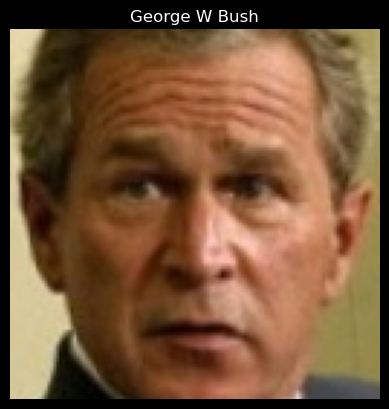

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

# 1. Завантаження даних (як у вас було)
print("Завантаження LFW dataset...")
faces = fetch_lfw_people(min_faces_per_person=100, 
                         slice_=None,    # Завантажуємо повні фото
                         resize=1.0, 
                         color=True)    # color=True важливо для CNN (3 канали)

# 2. Обрізка (Crop) - повторюємо логіку вашого коду
# Ви берете зріз [60:188, 60:188]. Це 128x128 пікселів.
images = faces.images[:, 60:188, 60:188, :] 

# Отримуємо мітки
labels = faces.target
target_names = faces.target_names

print(f"Розмір після кропу: {images.shape}") 
# Має бути (N, 128, 128, 3) - де N кількість фото

# 3. Підготовка даних для PyTorch
# Важливо: Scikit-learn повертає значення 0...255 або 0...1 (залежить від версії), 
# але зазвичай це float32 [0, 1]. Перевіримо це.
# PyTorch очікує формат: (Batch_Size, Channels, Height, Width)

# Трансформація (N, H, W, C) -> (N, C, H, W)
images_torch = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
labels_torch = torch.tensor(labels, dtype=torch.long)

# 4. Розбивка на Train / Test (стандартна практика для диплому)
X_train, X_test, y_train, y_test = train_test_split(
    images_torch, labels_torch, test_size=0.2, random_state=42, stratify=labels_torch
)

# 5. Створення DataLoader'ів
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Дані готові. Кількість класів: {len(target_names)}")
print(f"Формат тензора для моделі: {X_train.shape}") # Має бути [N, 3, 128, 128]

# --- Перевірка: виведемо картинку, щоб переконатися, що все ок ---
def show_one_image(tensor_img, label_idx):
    # Повертаємо канали назад для відображення matplotlib: (C, H, W) -> (H, W, C)
    img_np = tensor_img.permute(1, 2, 0).numpy()
    plt.imshow(img_np)
    plt.title(target_names[label_idx])
    plt.axis('off')
    plt.show()

# Покажемо перше фото з тренувального набору
show_one_image(X_train[0], y_train[0])

In [2]:
target_names

array(['Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Tony Blair'], dtype='<U17')

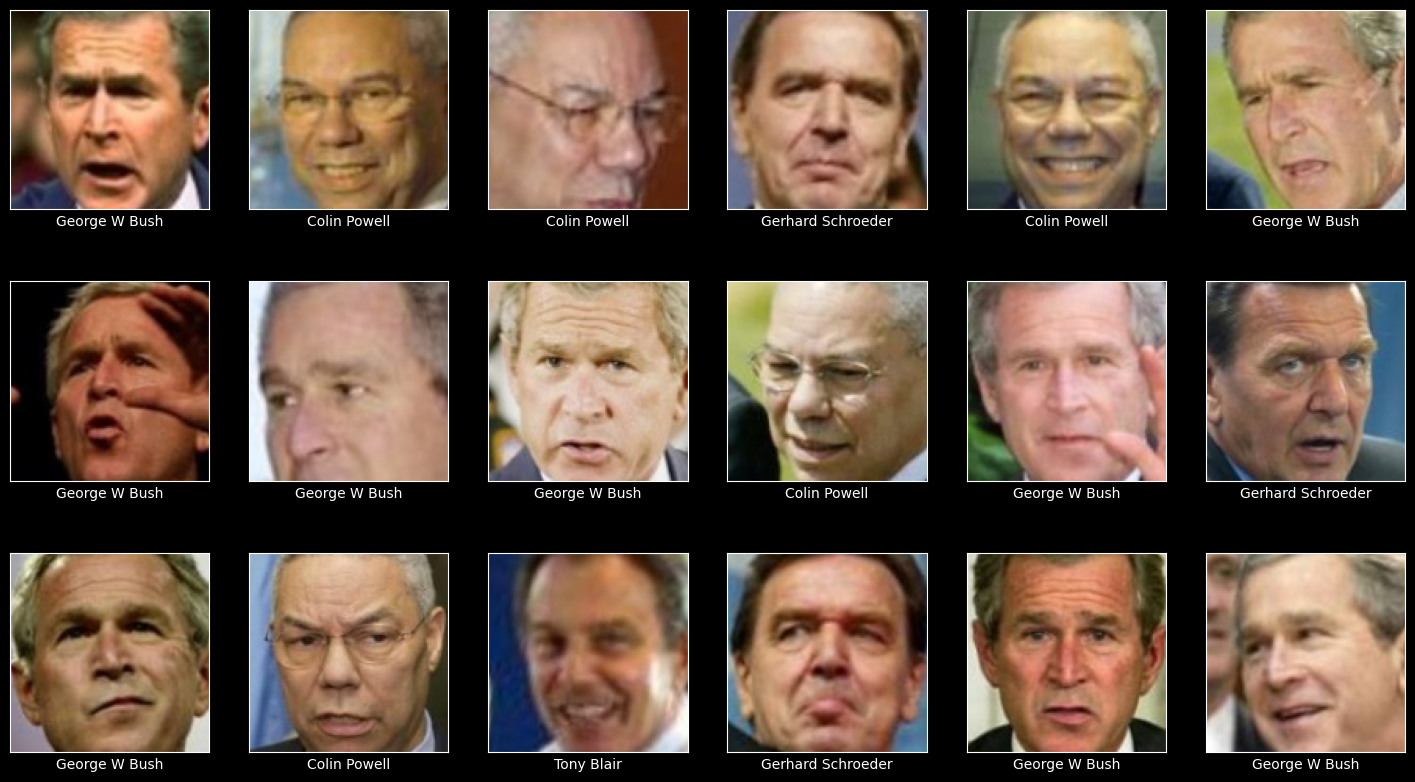

In [3]:
# import matplotlib.pyplot as plt
# import numpy as np

# Отримуємо один пакет (батч) зображень з нашого train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter) # images має форму [32, 3, 128, 128]

# Налаштовуємо сітку для малювання (3 рядки по 6 картинок)
fig, axes = plt.subplots(3, 6, figsize=(18, 10))

# Проходимось по осях (axes) та картинках
for i, ax in enumerate(axes.flat):
    # Перевірка, щоб не вийти за межі батчу (якщо він менший за 18)
    if i >= len(images):
        break
        
    # 1. Беремо i-ту картинку з тензора
    img_tensor = images[i] 
    
    # 2. Перетворення для matplotlib:
    # PyTorch: (C, H, W) -> (3, 128, 128)
    # Matplotlib хоче: (H, W, C) -> (128, 128, 3)
    img_display = img_tensor.permute(1, 2, 0).numpy()
    
    # Нормалізація для відображення (якщо дані вийшли за межі [0, 1])
    # Це корисно, якщо ми використовували нормалізацію середнього/відхилення
    img_display = np.clip(img_display, 0, 1)

    # 3. Відображення
    ax.imshow(img_display)
    
    # Отримуємо текстову назву класу по індексу
    label_idx = labels[i].item()
    name = target_names[label_idx]
    
    # Прибираємо осі та додаємо підпис
    ax.set(xticks=[], yticks=[], xlabel=name)

plt.show()

In [4]:
# Перевірка даних
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Max value: {images.max()}")
print(f"Min value: {images.min()}")

Max value: 1.0
Min value: 0.0


In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FaceNet(nn.Module):
    def __init__(self, num_classes):
        super(FaceNet, self).__init__()
        
        # 1. Conv2D(32, (3, 3), activation='relu')
        # Вхід: 3 канали (RGB), Вихід: 32 канали
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        
        # 2. MaxPooling2D(2, 2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 3. Conv2D(64, (3, 3), activation='relu')
        self.conv2 = nn.Conv2d(32, 64, 3)
        
        # 4. Conv2D(64, (3, 3), activation='relu')
        self.conv3 = nn.Conv2d(64, 64, 3)
        
        # 5. Flatten + Dense(1024)
        # Нам треба порахувати розмір входу: 64 канали * 14 * 14 (розмір після 3 пулінгів)
        self.fc1 = nn.Linear(64 * 14 * 14, 1024)
        
        # 6. Dense(class_count, activation='softmax')
        self.fc2 = nn.Linear(1024, num_classes)
        # Примітка: Softmax тут не пишемо, він буде всередині функції втрат CrossEntropyLoss

    def forward(self, x):
        # Блок 1
        x = self.pool(F.relu(self.conv1(x)))
        # Блок 2
        x = self.pool(F.relu(self.conv2(x)))
        # Блок 3
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten (розгортання в вектор)
        x = x.view(x.size(0), -1) 
        
        # Повнозв'язні шари
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Визначення пристрою (GPU або CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Тренування на: {device}")

# Ініціалізація моделі
# class_count ми отримали в попередніх кроках (len(target_names))
model = FaceNet(num_classes=len(target_names)).to(device)

# Функція втрат та оптимізатор
# CrossEntropyLoss у PyTorch вже включає в себе Softmax!
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr за замовчуванням в Keras

Тренування на: cpu


In [14]:
num_epochs = 15

# Список для збереження історії втрат (щоб потім побудувати графік)
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train() # Перемикаємо модель у режим тренування
    running_loss = 0.0
    
    for images, labels in train_loader:
        # Переносимо дані на GPU
        images, labels = images.to(device), labels.to(device)
        
        # НОРМАЛІЗАЦІЯ (аналог x_train / 255)
        # Важливо робити це тут, якщо ви не зробили transforms.ToTensor() раніше
        # images = images / 255.0 
        
        # 1. Обнулення градієнтів
        optimizer.zero_grad()
        
        # 2. Forward pass (прогноз)
        outputs = model(images)
        
        # 3. Обчислення помилки
        loss = criterion(outputs, labels)
        
        # 4. Backward pass (обчислення градієнтів)
        loss.backward()
        
        # 5. Оновлення ваг
        optimizer.step()
        
        running_loss += loss.item()
    
    # Середня помилка за епоху
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- Валідація (аналог validation_data) ---
    model.eval() # Режим оцінки (вимикає dropout і т.д.)
    correct = 0
    total = 0
    
    with torch.no_grad(): # Не рахуємо градієнти для тесту (економить пам'ять)
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # images = images / 255.0 # Не забуваємо нормалізувати і тут!
            
            outputs = model(images)
            # Отримуємо клас з найвищою ймовірністю
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

print("Тренування завершено!")

Epoch [1/15], Loss: 1.4905, Validation Accuracy: 46.49%
Epoch [2/15], Loss: 1.4130, Validation Accuracy: 46.49%
Epoch [3/15], Loss: 1.2979, Validation Accuracy: 52.19%
Epoch [4/15], Loss: 0.8142, Validation Accuracy: 77.19%
Epoch [5/15], Loss: 0.5421, Validation Accuracy: 83.77%
Epoch [6/15], Loss: 0.3441, Validation Accuracy: 87.72%
Epoch [7/15], Loss: 0.2374, Validation Accuracy: 85.96%
Epoch [8/15], Loss: 0.2024, Validation Accuracy: 88.60%
Epoch [9/15], Loss: 0.1167, Validation Accuracy: 89.47%
Epoch [10/15], Loss: 0.0688, Validation Accuracy: 89.91%
Epoch [11/15], Loss: 0.0364, Validation Accuracy: 90.79%
Epoch [12/15], Loss: 0.0217, Validation Accuracy: 88.60%
Epoch [13/15], Loss: 0.0874, Validation Accuracy: 87.72%
Epoch [14/15], Loss: 0.0872, Validation Accuracy: 90.79%
Epoch [15/15], Loss: 0.0229, Validation Accuracy: 89.47%
Тренування завершено!


In [7]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, test_accuracies):
    plt.figure(figsize=(14, 5))

    # Визначаємо кількість епох на основі довжини списку даних
    epochs_count = len(train_losses)
    # Створюємо список міток для осі X: від 0 до останньої епохи з кроком 5
    # Використовуємо range(0, epochs_count + 1, 5)
    x_ticks = range(0, epochs_count + 1, 5)

    # Графік 1: Функція втрат (Loss)
    # Вона має падати вниз
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='red')
    plt.xlabel('Епоха')
    plt.ylabel('Loss')
    plt.title('Динаміка помилки (Loss)')
    plt.grid(True)
    plt.legend()
    plt.ylim(bottom=0)        # Y починається з 0
    plt.xticks(x_ticks)       # X має крок 5

    # Графік 2: Точність (Accuracy)
    # Вона має зростати
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Епоха')
    plt.ylabel('Точність (%)')
    plt.title('Динаміка точності на тестових даних')
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 100)          # Y від 0 до 100%
    plt.xticks(x_ticks)       # X має крок 5

    plt.show()

# Виклик функції
plot_training_history(train_losses, test_accuracies)

NameError: name 'train_losses' is not defined

In [16]:
# Вказуємо шлях до файлу
model_path = 'facenet_lfw_model.pth'

# Зберігаємо лише ваги (параметри) моделі
torch.save(model.state_dict(), model_path)

print(f"Модель успішно збережено у файл: {model_path}")

Модель успішно збережено у файл: facenet_lfw_model.pth


In [8]:
# 1. Спочатку треба створити "порожній" екземпляр такої ж архітектури
# Важливо: кількість класів має співпадати з тією, на якій тренували!
loaded_model = FaceNet(num_classes=len(target_names))

# 2. Завантажуємо ваги з файлу
loaded_model.load_state_dict(torch.load('facenet_lfw_model.pth'))

# 3. Переводимо модель на той пристрій, де будемо працювати (CPU або GPU)
loaded_model = loaded_model.to(device)

# 4. ВАЖЛИВО: Перемикаємо в режим оцінки (Evaluation mode)
# Це фіксує шари Dropout та BatchNorm (якщо вони є)
loaded_model.eval()

print("Модель завантажено і готово до передбачень!")

Модель завантажено і готово до передбачень!


2026-01-09 10:48:07.036768: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt/conda/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/opt

Обличчя знайдено: confidence 1.00


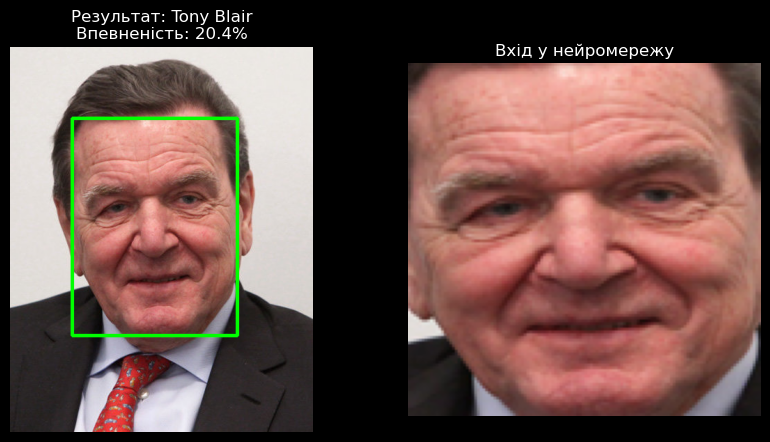

Обличчя знайдено: confidence 1.00


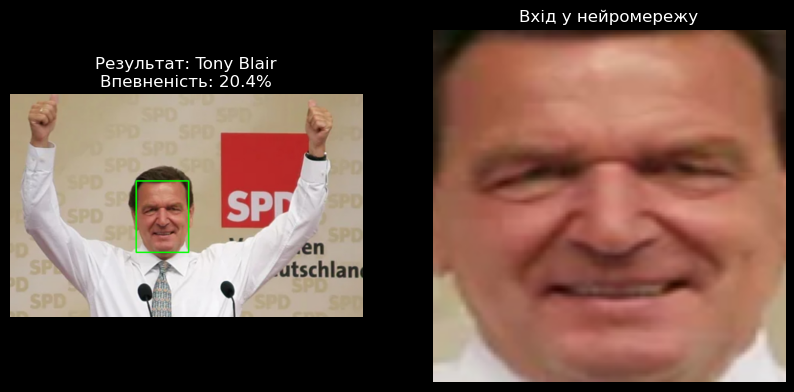

Обличчя знайдено: confidence 1.00


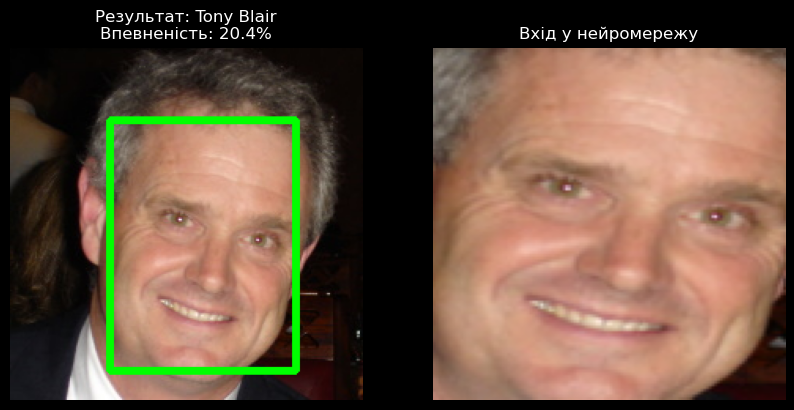

np.str_('Tony Blair')

In [9]:
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Імпортуємо стандартний MTCNN (який працює через TensorFlow)
from mtcnn import MTCNN

# Шлях до файлу
known_image_path = "Data/Faces/Gerhard_Schröder_20160112_03_(cropped).jpg"
known_image2_path = 'Data/Faces/Gerhard_Schröder_20160112_03_younger.jpg'
unknown_image_path = "Data/Faces/Jeff-1.jpg"

# Ініціалізація детектора (робимо це один раз)
detector = MTCNN()

def predict_person_tf_mtcnn(image_path, model, class_names, detector):
    # 1. Зчитування картинки
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Помилка: Не вдалося знайти файл {image_path}")
        return
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    vis_img = img_rgb.copy() # Копія для малювання

    # 2. Детекція через стандартний MTCNN
    # Цей метод повертає список словників: [{'box': [x, y, w, h], 'confidence': 0.99, ...}]
    results = detector.detect_faces(img_rgb)

    face_img = None
    
    if not results:
        print("MTCNN не знайшов обличчя! Використовую повне зображення.")
        # Якщо не знайшли, просто беремо весь кадр
        face_img = Image.fromarray(img_rgb).resize((128, 128))
    else:
        # Беремо обличчя з найвищою впевненістю (зазвичай перше, але перестрахуємось)
        best_face = max(results, key=lambda x: x['confidence'])
        
        x, y, w, h = best_face['box']
        
        # MTCNN іноді повертає негативні координати (якщо обличчя на краю), фіксимо це:
        x, y = max(0, x), max(0, y)
        
        # Малюємо бокс
        cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 3)
        
        # Вирізаємо обличчя
        # NumPy slice: [y:y+h, x:x+w]
        face_array = img_rgb[y:y+h, x:x+w]
        
        # Конвертуємо в PIL та робимо ресайз, який очікує наша модель
        face_img = Image.fromarray(face_array).resize((128, 128))
        print(f"Обличчя знайдено: confidence {best_face['confidence']:.2f}")

    # 3. Підготовка до PyTorch моделі
    transform = transforms.Compose([
        transforms.ToTensor() # Переводить в діапазон [0, 1] та формат (C, H, W)
    ])
    
    # [3, 128, 128] -> [1, 3, 128, 128]
    input_tensor = transform(face_img).unsqueeze(0).to(device)

    # 4. Прогноз (Inference)
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)
        
    predicted_name = class_names[predicted_idx.item()]
    confidence_val = confidence.item() * 100

    # 5. Відображення
    plt.figure(figsize=(10, 5))
    
    # Оригінал
    plt.subplot(1, 2, 1)
    plt.imshow(vis_img)
    plt.title(f"Результат: {predicted_name}\nВпевненість: {confidence_val:.1f}%")
    plt.axis('off')
    
    # Те, що бачить модель
    plt.subplot(1, 2, 2)
    plt.imshow(face_img)
    plt.title("Вхід у нейромережу")
    plt.axis('off')
    
    plt.show()
    
    return predicted_name

# --- ЗАПУСК ---
predict_person_tf_mtcnn(known_image_path, model, target_names, detector)
predict_person_tf_mtcnn(known_image2_path, model, target_names, detector)
predict_person_tf_mtcnn(unknown_image_path, model, target_names, detector)

In [10]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# 1. Завантажуємо попередньо навчену модель ResNet50
# weights='DEFAULT' завантажує найкращі доступні ваги (ImageNet)
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# 2. "Заморожуємо" ваги базової моделі
# Ми кажемо PyTorch не рахувати градієнти для цих шарів, щоб вони не змінювались
for param in resnet.parameters():
    param.requires_grad = False

# 3. Замінюємо останній повнозв'язний шар (fc)
# В оригіналі ResNet50 вихід fc має 1000 класів (ImageNet). 
# Ми змінюємо його на кількість наших людей (len(target_names)).

# Дізнаємося кількість входів у останній шар (у ResNet50 це 2048)
in_features = resnet.fc.in_features

# Створюємо новий шар. За замовчуванням requires_grad=True для нових шарів.
resnet.fc = nn.Linear(in_features, len(target_names))

# 4. Переносимо модель на GPU/CPU
resnet = resnet.to(device)

print("Модель ResNet50 завантажена та адаптована.")

Модель ResNet50 завантажена та адаптована.


In [11]:
# Налаштовуємо Loss та Optimizer
criterion = nn.CrossEntropyLoss()

# Важливо: оптимізуємо тільки останній шар (classifier head)
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

num_epochs = 15
train_losses = []
test_accuracies = []

print("Починаємо трансферне навчання ResNet50...")

for epoch in range(num_epochs):
    resnet.train() 
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # ResNet очікує нормалізовані дані, але оскільки ми вчимо тільки голову,
        # то просте [0, 1] теж спрацює непогано.
        
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- Валідація ---
    resnet.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')

print("Тренування завершено!")

Починаємо трансферне навчання ResNet50...


KeyboardInterrupt: 

In [21]:
torch.save(resnet.state_dict(), 'resnet50_lfw_transfer.pth')
print("Модель ResNet50 збережено.")

Модель ResNet50 збережено.


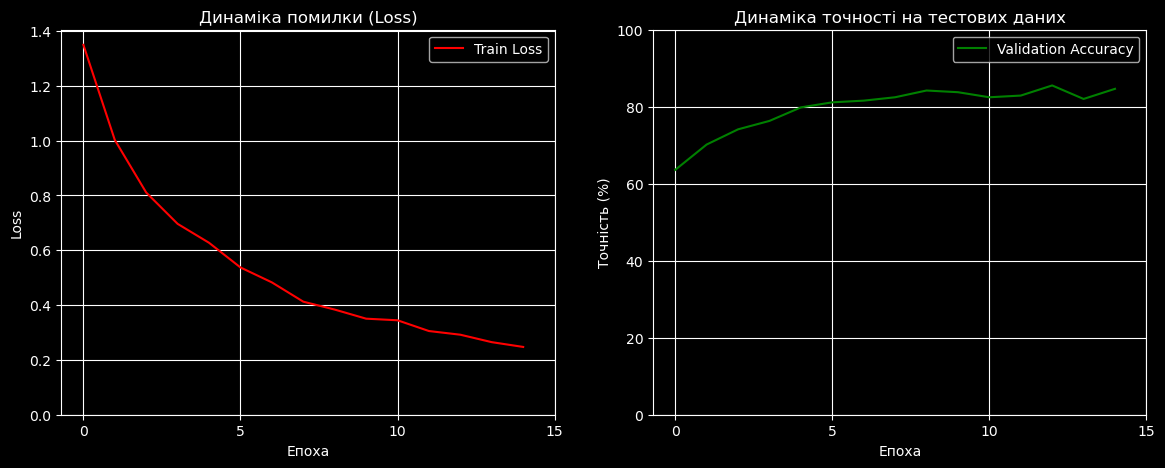

In [22]:
# import matplotlib.pyplot as plt

# def plot_training_history(train_losses, test_accuracies):
#     plt.figure(figsize=(14, 5))

#     # Визначаємо кількість епох на основі довжини списку даних
#     epochs_count = len(train_losses)
#     # Створюємо список міток для осі X: від 0 до останньої епохи з кроком 5
#     # Використовуємо range(0, epochs_count + 1, 5)
#     x_ticks = range(0, epochs_count + 1, 5)

#     # Графік 1: Функція втрат (Loss)
#     # Вона має падати вниз
#     plt.subplot(1, 2, 1)
#     plt.plot(train_losses, label='Train Loss', color='red')
#     plt.xlabel('Епоха')
#     plt.ylabel('Loss')
#     plt.title('Динаміка помилки (Loss)')
#     plt.grid(True)
#     plt.legend()
#     plt.ylim(bottom=0)        # Y починається з 0
#     plt.xticks(x_ticks)       # X має крок 5

#     # Графік 2: Точність (Accuracy)
#     # Вона має зростати
#     plt.subplot(1, 2, 2)
#     plt.plot(test_accuracies, label='Validation Accuracy', color='green')
#     plt.xlabel('Епоха')
#     plt.ylabel('Точність (%)')
#     plt.title('Динаміка точності на тестових даних')
#     plt.grid(True)
#     plt.legend()
#     plt.ylim(0, 100)          # Y від 0 до 100%
#     plt.xticks(x_ticks)       # X має крок 5

#     plt.show()

# Виклик функції
plot_training_history(train_losses, test_accuracies)

In [12]:
import torch
import torch.nn as nn
from torchvision import models
from mtcnn import MTCNN
import cv2
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Налаштування девайсу
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Відтворення архітектури моделі ---
def load_classification_model(model_path, num_classes):
    print("Завантаження ResNet50 для класифікації...")
    
    # Завантажуємо структуру ResNet50
    # weights=None, бо ми все одно перезапишемо їх своїми збереженими вагами
    model = models.resnet50(weights=None) 
    
    # Замінюємо останній шар (так само, як робили при навчанні)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    # Завантажуємо збережені ваги
    # map_location='cpu' важливий, якщо ви вчили на GPU, а запускаєте на CPU
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    model = model.to(device)
    model.eval() # Обов'язково перемикаємо в режим оцінки!
    print("Модель успішно завантажена.")
    return model

# Припускаємо, що target_names у вас залишився в пам'яті після завантаження датасету
# Якщо ні - вам треба відновити список імен у тому ж порядку, що при тренуванні!
num_classes = len(target_names)
model_path = 'resnet50_lfw_transfer.pth' # Ім'я файлу, яке ми використовували для ResNet класифікатора

# Ініціалізація
cls_model = load_classification_model(model_path, num_classes)
detector = MTCNN() # Детектор облич

Завантаження ResNet50 для класифікації...


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


Модель успішно завантажена.


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


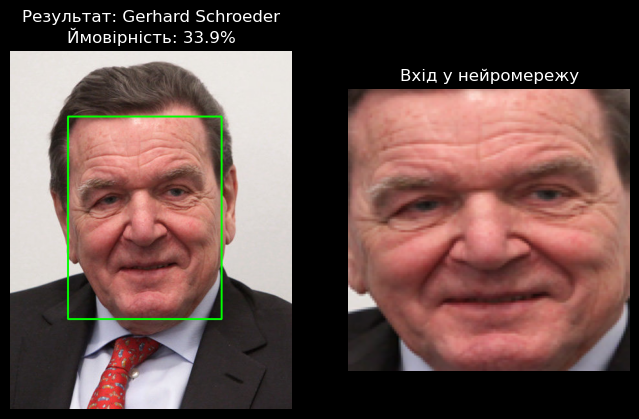

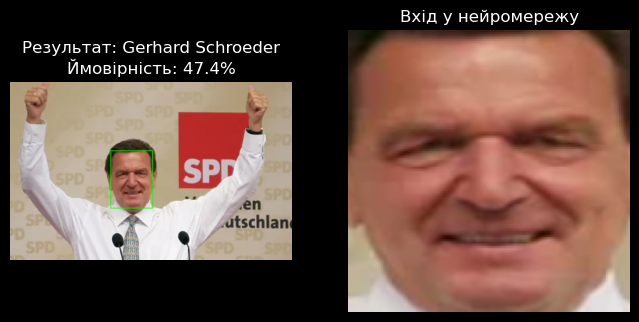

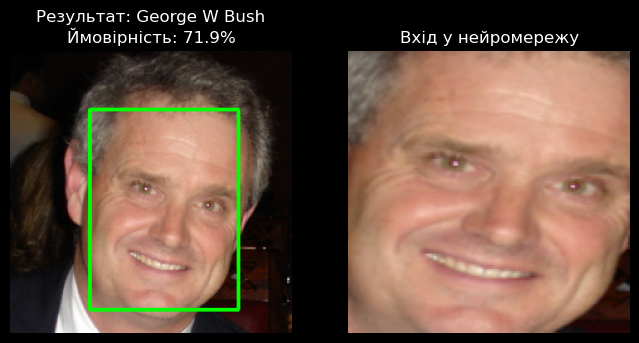

(np.str_('George W Bush'), 71.88412547111511)

In [13]:
def predict_face_classification(image_path, model, class_names, detector):
    # 1. Завантаження та детекція
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Не знайдено файл: {image_path}")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    vis_img = img_rgb.copy() # Копія для малювання
    
    # Використовуємо MTCNN для пошуку
    results = detector.detect_faces(img_rgb)
    
    if not results:
        print("Обличчя не знайдено!")
        return

    # Беремо найвпевненіше обличчя
    best_face = max(results, key=lambda x: x['confidence'])
    x, y, w, h = best_face['box']
    x, y = max(0, x), max(0, y) # Фікс від'ємних координат
    
    # Малюємо рамку
    cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # 2. Підготовка обличчя (Crop -> Resize -> Tensor)
    face_img = Image.fromarray(img_rgb[y:y+h, x:x+w]).resize((128, 128))
    
    transform = transforms.Compose([
        transforms.ToTensor() # [0, 255] -> [0.0, 1.0]
    ])
    
    input_tensor = transform(face_img).unsqueeze(0).to(device)
    
    # 3. Прогноз моделі
    with torch.no_grad():
        outputs = model(input_tensor)
        
        # Застосовуємо Softmax, щоб отримати ймовірності у відсотках
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
        # Знаходимо клас з максимальною ймовірністю
        confidence, predicted_idx = torch.max(probabilities, 1)
        
    idx = predicted_idx.item()
    predicted_name = class_names[idx]
    confidence_val = confidence.item() * 100
    
    # 4. Візуалізація
    plt.figure(figsize=(8, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(vis_img)
    plt.title(f"Результат: {predicted_name}\nЙмовірність: {confidence_val:.1f}%")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(face_img)
    plt.title("Вхід у нейромережу")
    plt.axis('off')
    
    plt.show()
    
    return predicted_name, confidence_val

# --- ЗАПУСК ---

predict_face_classification(known_image_path, cls_model, target_names, detector)
predict_face_classification(known_image2_path, cls_model, target_names, detector)
predict_face_classification(unknown_image_path, cls_model, target_names, detector)

In [14]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class TripletFaceDataset(Dataset):
    def __init__(self, images, labels):
        """
        images: тензор усіх картинок (N, 3, 128, 128)
        labels: тензор міток (N)
        """
        self.images = images
        self.labels = labels
        self.labels_set = set(labels.numpy())
        
        # Створюємо словник {label: [index1, index2, ...]} для швидкого пошуку
        self.label_to_indices = {label: np.where(labels.numpy() == label)[0]
                                 for label in self.labels_set}

    def __getitem__(self, index):
        # 1. ANCHOR (Якір) - беремо картинку за індексом
        img_anchor = self.images[index]
        label = self.labels[index].item()
        
        # 2. POSITIVE (Позитивний приклад) - інше фото тієї ж людини
        # Беремо всі індекси цієї людини
        positive_indices = self.label_to_indices[label]
        # Вибираємо випадковий індекс, відмінний від anchor (якщо є вибір)
        positive_index = index
        if len(positive_indices) > 1:
            while positive_index == index:
                positive_index = np.random.choice(positive_indices)
        
        img_positive = self.images[positive_index]
        
        # 3. NEGATIVE (Негативний приклад) - фото іншої людини
        # Вибираємо випадковий клас, відмінний від поточного
        negative_label = np.random.choice(list(self.labels_set - {label}))
        # Вибираємо випадкове фото цього "чужого" класу
        negative_index = np.random.choice(self.label_to_indices[negative_label])
        
        img_negative = self.images[negative_index]
        
        return img_anchor, img_positive, img_negative

    def __len__(self):
        return len(self.images)

# --- Створення DataLoader'ів ---
# Використовуємо X_train, y_train з попередніх кроків
triplet_train_dataset = TripletFaceDataset(X_train, y_train)
# Для тесту теж можна використовувати трійки, щоб міряти loss
triplet_test_dataset = TripletFaceDataset(X_test, y_test)

batch_size = 32
triplet_train_loader = DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True)
triplet_test_loader = DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False)

print("Triplet Dataset готовий.")

Triplet Dataset готовий.


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class FaceNetTriplet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(FaceNetTriplet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        
        # Вхід: 64 канали * 14 * 14
        self.fc1 = nn.Linear(64 * 14 * 14, 1024)
        
        # ВИХІД: тепер не класи, а вектор Embedding (наприклад, 128)
        self.fc2 = nn.Linear(1024, embedding_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # ВАЖЛИВО: L2 Нормалізація вектора (щоб довжина була = 1)
        x = F.normalize(x, p=2, dim=1)
        return x

In [16]:
from torchvision import models

class ResNetTriplet(nn.Module):
    def __init__(self, embedding_dim=128):
        super(ResNetTriplet, self).__init__()
        # Завантажуємо backbone
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # Заморожуємо ваги (якщо треба)
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # Замінюємо голову
        in_features = self.resnet.fc.in_features
        # Тут просто лінійний шар на 128 виходів
        self.resnet.fc = nn.Linear(in_features, embedding_dim)
        
    def forward(self, x):
        x = self.resnet(x)
        # Нормалізація
        x = F.normalize(x, p=2, dim=1)
        return x

In [28]:
import torch.optim as optim

def train_triplet_model(model, train_loader, num_epochs=10, margin=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Використовуємо TripletMarginLoss
    criterion = nn.TripletMarginLoss(margin=margin, p=2)
    
    # Для ResNet треба оптимізувати тільки fc, для своєї - все
    if isinstance(model, ResNetTriplet):
        optimizer = optim.Adam(model.resnet.fc.parameters(), lr=0.001)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # Тепер loader віддає 3 картинки
        for anchor, positive, negative in train_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            optimizer.zero_grad()
            
            # 3 прогони через модель (або один, якщо об'єднати в батч)
            emb_anchor = model(anchor)
            emb_pos = model(positive)
            emb_neg = model(negative)
            
            # Рахуємо Triplet Loss
            loss = criterion(emb_anchor, emb_pos, emb_neg)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
    return train_losses

# --- ЗАПУСК ТРЕНУВАННЯ ---

# 1. Тренуємо просту CNN
print("Тренуємо Simple CNN з Triplet Loss...")
simple_model = FaceNetTriplet(embedding_dim=128)
losses_simple = train_triplet_model(simple_model, triplet_train_loader, num_epochs=15)

# 2. Тренуємо ResNet50
print("\nТренуємо ResNet50 з Triplet Loss...")
resnet_model = ResNetTriplet(embedding_dim=128)
losses_resnet = train_triplet_model(resnet_model, triplet_train_loader, num_epochs=15)

Тренуємо Simple CNN з Triplet Loss...
Epoch [1/15], Loss: 0.9688
Epoch [2/15], Loss: 0.9207
Epoch [3/15], Loss: 0.7462
Epoch [4/15], Loss: 0.6084
Epoch [5/15], Loss: 0.4820
Epoch [6/15], Loss: 0.3598
Epoch [7/15], Loss: 0.3333
Epoch [8/15], Loss: 0.2829
Epoch [9/15], Loss: 0.2375
Epoch [10/15], Loss: 0.1746
Epoch [11/15], Loss: 0.1548
Epoch [12/15], Loss: 0.1456
Epoch [13/15], Loss: 0.1281
Epoch [14/15], Loss: 0.0881
Epoch [15/15], Loss: 0.0972

Тренуємо ResNet50 з Triplet Loss...
Epoch [1/15], Loss: 0.9220
Epoch [2/15], Loss: 0.7054
Epoch [3/15], Loss: 0.5032
Epoch [4/15], Loss: 0.4285
Epoch [5/15], Loss: 0.3400
Epoch [6/15], Loss: 0.2921
Epoch [7/15], Loss: 0.2416
Epoch [8/15], Loss: 0.2106
Epoch [9/15], Loss: 0.2106
Epoch [10/15], Loss: 0.1731
Epoch [11/15], Loss: 0.1546
Epoch [12/15], Loss: 0.1461
Epoch [13/15], Loss: 0.1450
Epoch [14/15], Loss: 0.1142
Epoch [15/15], Loss: 0.1128


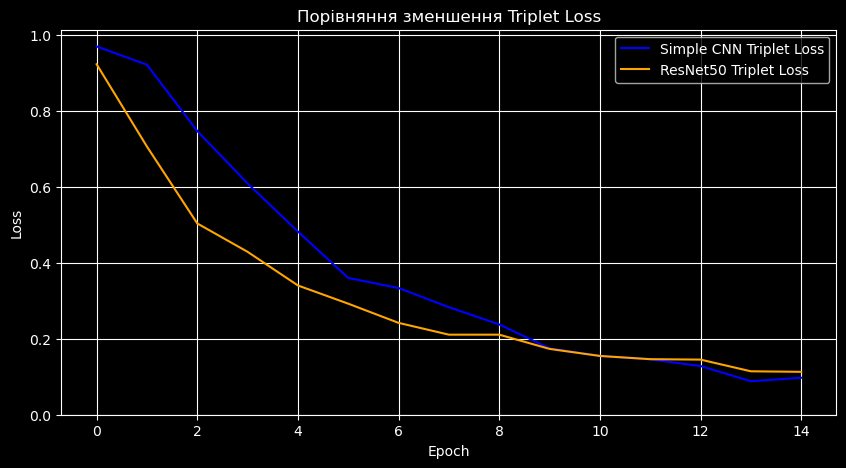

In [29]:
import matplotlib.pyplot as plt

def plot_losses(losses_simple, losses_resnet):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_simple, label='Simple CNN Triplet Loss', color='blue')
    plt.plot(losses_resnet, label='ResNet50 Triplet Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Порівняння зменшення Triplet Loss')
    plt.ylim(bottom=0)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(losses_simple, losses_resnet)

In [30]:
# Зберігаємо просту модель
torch.save(simple_model.state_dict(), 'facenet_triplet.pth')

# Зберігаємо ResNet модель
torch.save(resnet_model.state_dict(), 'resnet50_triplet.pth')

print("Моделі збережено успішно.")

Моделі збережено успішно.


In [17]:
def load_saved_model(model_class, filepath, device):
    print(f"Завантаження {filepath}...")
    
    # 1. Створюємо екземпляр моделі
    model = model_class(embedding_dim=128)
    
    # 2. Завантажуємо ваги
    # map_location важливий, якщо ви тренували на GPU, а завантажуєте на CPU (або навпаки)
    try:
        model.load_state_dict(torch.load(filepath, map_location=device))
        print("✅ Успішно завантажено.")
    except FileNotFoundError:
        print(f"❌ Файл {filepath} не знайдено!")
        return None
    except RuntimeError as e:
        print(f"❌ Помилка архітектури: {e}")
        return None

    # 3. Переносимо на пристрій і перемикаємо в режим оцінки
    model = model.to(device)
    model.eval() # Це фіксує Dropout і BatchNorm
    return model

# --- ЗАВАНТАЖЕННЯ ---

# Шляхи до файлів
path_simple = 'facenet_triplet.pth'
path_resnet = 'resnet50_triplet.pth'

# Завантажуємо обидві моделі в пам'ять
simple_model_loaded = load_saved_model(FaceNetTriplet, path_simple, device)
resnet_model_loaded = load_saved_model(ResNetTriplet, path_resnet, device)

# --- ПЕРЕВІРКА ---
# Проженемо випадковий тензор, щоб переконатися, що все працює
if resnet_model_loaded:
    dummy_input = torch.randn(1, 3, 128, 128).to(device)
    with torch.no_grad():
        output = resnet_model_loaded(dummy_input)
    print(f"\nТестовий вихідний вектор має розмір: {output.shape}") 
    # Має бути torch.Size([1, 128])

Завантаження facenet_triplet.pth...
✅ Успішно завантажено.
Завантаження resnet50_triplet.pth...
✅ Успішно завантажено.

Тестовий вихідний вектор має розмір: torch.Size([1, 128])


In [21]:
def create_embedding_database(model, data_loader, device):
    model.eval()
    embeddings_db = {}
    counts = {}
    
    print("Генеруємо базу векторів...")
    
    with torch.no_grad():
        # Тут нам потрібен звичайний DataLoader (не Triplet!), який віддає (image, label)
        # Ми створили його на самому початку як 'train_loader'
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Отримуємо вектори
            embeddings = model(images)
            
            for i in range(len(labels)):
                label_idx = labels[i].item()
                emb = embeddings[i].cpu() # Переносимо на CPU для зберігання
                
                if label_idx not in embeddings_db:
                    embeddings_db[label_idx] = emb
                    counts[label_idx] = 1
                else:
                    embeddings_db[label_idx] += emb
                    counts[label_idx] += 1
    
    # Рахуємо середній вектор для кожної людини
    for label_idx in embeddings_db:
        embeddings_db[label_idx] /= counts[label_idx]
        # Нормалізуємо усереднений вектор ще раз (про всяк випадок)
        embeddings_db[label_idx] = torch.nn.functional.normalize(embeddings_db[label_idx].unsqueeze(0), p=2).squeeze(0)
        
    print(f"База створена. Кількість осіб: {len(embeddings_db)}")
    return embeddings_db

# --- ВИКОРИСТАННЯ ---
# Використовуємо ResNet (вона зазвичай краща) і звичайний train_loader (створений на початку чату)
# Якщо train_loader втрачено, створіть його знову з TensorDataset(X_train, y_train)
reference_db = create_embedding_database(resnet_model_loaded, train_loader, device)

Генеруємо базу векторів...
База створена. Кількість осіб: 5


In [22]:
from mtcnn import MTCNN
import cv2
from PIL import Image

# Ініціалізація детектора
detector = MTCNN()

def identify_face_triplet(image_path, model, database, class_names, threshold=0.8):
    """
    threshold: поріг відстані. Якщо відстань менша за це число - це match. 
               Якщо більша - "Невідомий". Для TripletLoss (margin=1.0) зазвичай 0.6-0.8 це ок.
    """
    # 1. Підготовка (Детекція + Препроцесинг)
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error: {image_path}")
        return
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    results = detector.detect_faces(img_rgb)
    
    if not results:
        print("Обличчя не знайдено.")
        return
        
    x, y, w, h = results[0]['box']
    x, y = max(0, x), max(0, y)
    face_img = Image.fromarray(img_rgb[y:y+h, x:x+w]).resize((128, 128))
    
    # Перетворюємо в тензор
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(face_img).unsqueeze(0).to(device)
    
    # 2. Отримання вектора (Embedding)
    model.eval()
    with torch.no_grad():
        # Отримуємо вектор нового обличчя
        query_emb = model(input_tensor).cpu()
        
    # 3. Пошук найближчого у базі (Nearest Neighbor)
    min_dist = float('inf')
    best_match_name = "Unknown"
    
    for label_idx, db_emb in database.items():
        # Рахуємо Евклідову відстань (L2 distance)
        # dist = || query - db ||
        dist = torch.dist(query_emb, db_emb, p=2).item()
        
        if dist < min_dist:
            min_dist = dist
            if dist < threshold:
                best_match_name = class_names[label_idx]
            else:
                best_match_name = "Unknown"

    # 4. Візуалізація
    plt.figure(figsize=(6, 6))
    vis_img = img_rgb.copy()
    color = (0, 255, 0) if best_match_name != "Unknown" else (255, 0, 0)
    cv2.rectangle(vis_img, (x, y), (x+w, y+h), color, 2)
    
    plt.imshow(vis_img)
    plt.title(f"Результат: {best_match_name}\nВідстань: {min_dist:.4f}")
    plt.axis('off')
    plt.show()
    
    return best_match_name, min_dist



Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


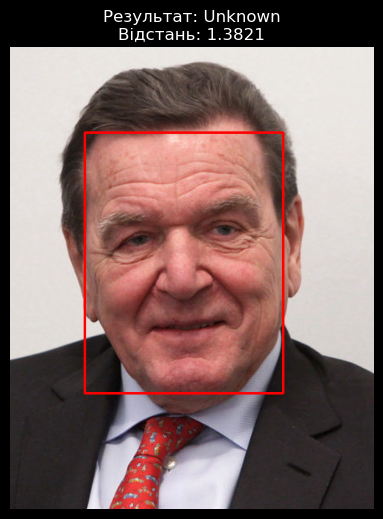

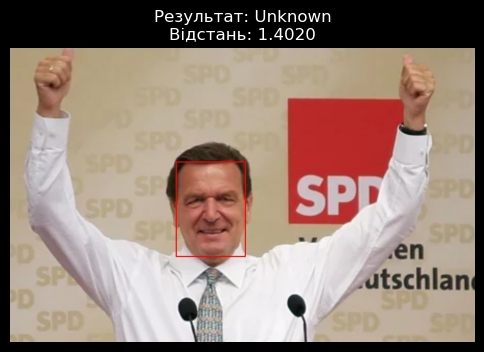

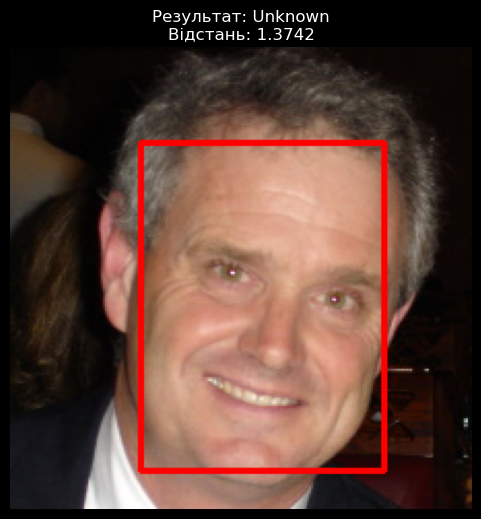

('Unknown', 1.374207615852356)

In [23]:
# --- ЗАПУСК ---

# Використовуємо  FaceNet модель
identify_face_triplet(known_image_path, simple_model_loaded, reference_db, target_names)
identify_face_triplet(known_image2_path, simple_model_loaded, reference_db, target_names)
identify_face_triplet(unknown_image_path, simple_model_loaded, reference_db, target_names)

In [ ]:
# Шлях до файлу
known_image_path = "Data/Faces/Gerhard_Schröder_20160112_03_(cropped).jpg"
known_image2_path = 'Data/Faces/Gerhard_Schröder_20160112_03_younger.jpg'
unknown_image_path = "Data/Faces/Jeff-1.jpg"

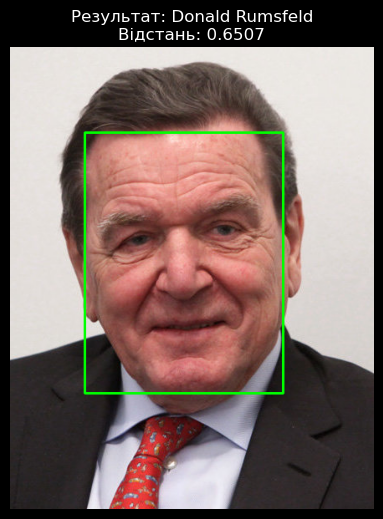

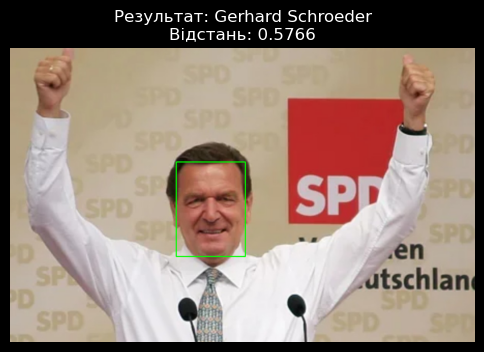

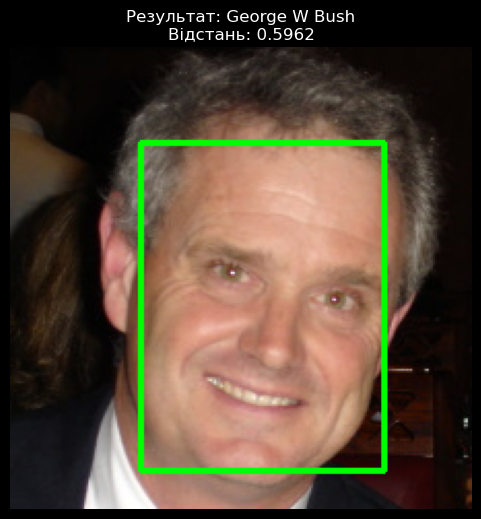

(np.str_('George W Bush'), 0.5961851477622986)

In [24]:
# --- ЗАПУСК ---

# Використовуємо ResNet модель
identify_face_triplet(known_image_path, resnet_model_loaded, reference_db, target_names)
identify_face_triplet(known_image2_path, resnet_model_loaded, reference_db, target_names)
identify_face_triplet(unknown_image_path, resnet_model_loaded, reference_db, target_names)

## Використання VGGFace2 як класифікатора

Використовується пристрій: cpu
Завантаження моделі...


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.13/site-packages/lz4/frame/__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


Завантаження метаданих з identity_meta.csv...
✅ Успішно завантажено імен: 9131

🔬 ЕКСПЕРИМЕНТ: Особа ВХОДИТЬ в Training Set (Gerhard Schröder)
📸 Файл: Gerhard_Schröder_20160112_03_(cropped).jpg
---------------------------------------------------------------------------
RANK  | NAME                                | ID         | CONFIDENCE
---------------------------------------------------------------------------
#1    | Richard_Galliano                    | n007335    | 0.06%
#2    | Mark_Dayton                         | n005684    | 0.05%
#3    | Krystle_Lina                        | n004914    | 0.05%
#4    | Essaïd_Belkalem                     | n002625    | 0.05%
#5    | Ludovic_Obraniak                    | n005320    | 0.05%


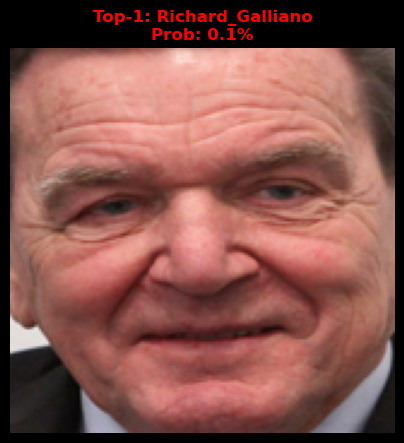


🔬 ЕКСПЕРИМЕНТ: Особа ВХОДИТЬ в Training Set (Gerhard Schröder)
📸 Файл: Gerhard_Schröder_20160112_03_younger.jpg
---------------------------------------------------------------------------
RANK  | NAME                                | ID         | CONFIDENCE
---------------------------------------------------------------------------
#1    | Sofía_Zámolo                        | n008133    | 0.06%
#2    | Ertharin_Cousin                     | n002616    | 0.06%
#3    | Krystle_Lina                        | n004914    | 0.06%
#4    | Nathan_Adrian                       | n006411    | 0.06%
#5    | Sean_Hannity                        | n007846    | 0.06%


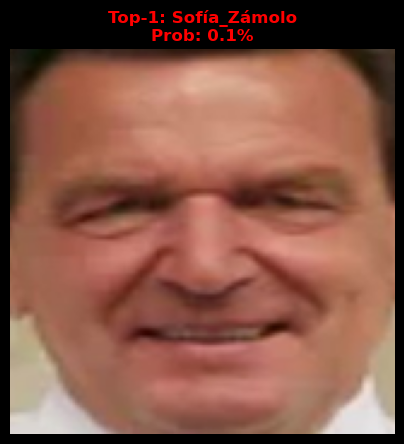


🔬 ЕКСПЕРИМЕНТ: Особа НЕ входить в Training Set (Abbey)
📸 Файл: Jeff-1.jpg
---------------------------------------------------------------------------
RANK  | NAME                                | ID         | CONFIDENCE
---------------------------------------------------------------------------
#1    | Mark_Rylance                        | n005695    | 0.08%
#2    | Alesia_Raut                         | n000235    | 0.07%
#3    | Tanja_Schumann                      | n008407    | 0.06%
#4    | Guy_Sebastian                       | n003265    | 0.06%
#5    | Sudeep                              | n008290    | 0.05%


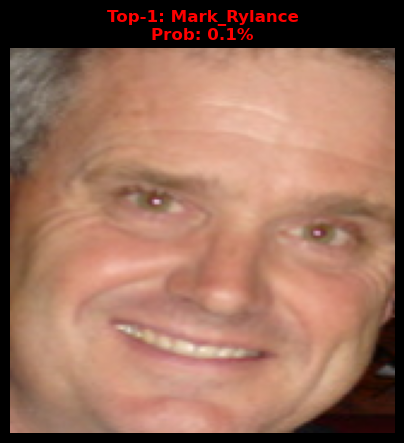

In [29]:
import torch
import torch.nn.functional as F
from facenet_pytorch import InceptionResnetV1
# Використовуємо стандартну бібліотеку mtcnn
from mtcnn import MTCNN 
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torchvision.transforms as transforms

# 1. Налаштування
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Використовується пристрій: {device}")

# 2. Завантаження моделі
print("Завантаження моделі...")
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=8631).to(device)
model.eval()

# 3. Детектор (ВИПРАВЛЕНО: без аргументів)
detector = MTCNN()

# --- КЛАС ДЛЯ РОБОТИ З МІТКАМИ (ВИПРАВЛЕНИЙ) ---
class VGGFace2Labels:
    def __init__(self, meta_path="identity_meta.csv"):
        self.idx_to_name = []
        self.idx_to_id = []
        
        if os.path.exists(meta_path):
            print(f"Завантаження метаданих з {meta_path}...")
            try:
                # ВИПРАВЛЕННЯ:
                # 1. sep=',' -> стандартний роздільник
                # 2. skipinitialspace=True -> ігнорує пробіли після коми (щоб " Name" стало "Name")
                # 3. quotechar='"' -> коректно обробляє коми всередині імен ("Doe, John")
                # 4. on_bad_lines='skip' -> якщо рядок все одно битий, ми його просто пропустимо, щоб код не падав
                
                try:
                    # Для нових версій pandas (1.3+)
                    df = pd.read_csv(meta_path, sep=',', skipinitialspace=True, quotechar='"', on_bad_lines='skip')
                except TypeError:
                    # Для старих версій pandas
                    df = pd.read_csv(meta_path, sep=',', skipinitialspace=True, quotechar='"', error_bad_lines=False)

                # Очистка назв стовпців
                df.columns = [c.strip() for c in df.columns]
                
                # Якщо pandas не зміг знайти заголовки автоматично
                if 'Class_ID' not in df.columns or 'Name' not in df.columns:
                     # Спробуємо ще раз без заголовків
                     try:
                        df = pd.read_csv(meta_path, sep=',', skipinitialspace=True, header=None, on_bad_lines='skip')
                     except:
                        df = pd.read_csv(meta_path, sep=',', skipinitialspace=True, header=None, error_bad_lines=False)
                     
                     # Присвоїмо імена першим двом колонкам
                     df = df.iloc[:, :2]
                     df.columns = ['Class_ID', 'Name']

                # Очистка даних
                df['Class_ID'] = df['Class_ID'].astype(str).str.strip().str.replace('"', '')
                df['Name'] = df['Name'].astype(str).str.strip().str.replace('"', '')
                
                # Сортуємо за ID (як при навчанні моделі)
                df = df.sort_values('Class_ID')
                
                self.idx_to_name = df['Name'].tolist()
                self.idx_to_id = df['Class_ID'].tolist()
                
                print(f"✅ Успішно завантажено імен: {len(self.idx_to_name)}")
                
            except Exception as e:
                print(f"❌ Критична помилка CSV: {e}")
                # Fallback: створимо пусті списки, щоб код не впав далі
                self.idx_to_name = ["Unknown"] * 8631
                self.idx_to_id = ["n000000"] * 8631
        else:
            print(f"❌ Файл {meta_path} не знайдено!")
            self.idx_to_name = ["Unknown"] * 8631
            self.idx_to_id = ["n000000"] * 8631

    def get_info(self, index):
        if 0 <= index < len(self.idx_to_name):
            return self.idx_to_name[index], self.idx_to_id[index]
        return "Unknown", "n000000"

labels_loader = VGGFace2Labels("identity_meta.csv")

# --- ФУНКЦІЯ ІНФЕРЕНСУ (Адаптована під mtcnn) ---

def predict_person(image_path, description):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"\n❌ Файл не знайдено: {image_path}")
        return

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # 1. Детекція
    results = detector.detect_faces(img_rgb)
    if not results:
        print(f"Обличчя не знайдено на {image_path}")
        return

    best_face = max(results, key=lambda x: x['confidence'])
    x, y, w, h = best_face['box']
    x, y = max(0, x), max(0, y)
    
    # 2. Вирізання та Ресайз
    face_arr = img_rgb[y:y+h, x:x+w]
    pil_img = Image.fromarray(face_arr).resize((160, 160))
    
    # 3. НОРМАЛІЗАЦІЯ (ВИПРАВЛЕНО)
    # facenet-pytorch для vggface2 очікує діапазон приблизно [-1, 1]
    # Формула: (x - 127.5) / 128.0
    
    # Переводимо в float numpy array [0, 255]
    face_arr_float = np.array(pil_img).astype(np.float32)
    
    # Стандартизація
    face_arr_norm = (face_arr_float - 127.5) / 128.0
    
    # Конвертація в тензор: (H, W, C) -> (C, H, W)
    face_tensor = torch.tensor(face_arr_norm).permute(2, 0, 1).float()
    
    # Додаємо Batch dimension
    input_tensor = face_tensor.unsqueeze(0).to(device)
    
    # 4. Передбачення
    with torch.no_grad():
        logits = model(input_tensor)
        probs = F.softmax(logits, dim=1)
        top_probs, top_classes = torch.topk(probs, 5)
        
    # --- Вивід результатів ---
    print(f"\n🔬 ЕКСПЕРИМЕНТ: {description}")
    print(f"📸 Файл: {os.path.basename(image_path)}")
    print("-" * 75)
    print(f"{'RANK':<5} | {'NAME':<35} | {'ID':<10} | {'CONFIDENCE'}")
    print("-" * 75)
    
    top_p = top_probs.cpu().numpy()[0]
    top_c = top_classes.cpu().numpy()[0]
    
    for i in range(5):
        idx = top_c[i]
        prob = top_p[i]
        name, class_id = labels_loader.get_info(idx)
        
        # Маркуємо Герхарда (ID n003047)
        marker = " <--- ЦІЛЬ!" if class_id == "n003047" else ""
        print(f"#{i+1:<4} | {name:<35} | {class_id:<10} | {prob*100:.2f}%{marker}")

    # Візуалізація
    plt.figure(figsize=(5, 5))
    plt.imshow(pil_img) # Показуємо оригінал (не нормалізований)
    
    top_name, _ = labels_loader.get_info(top_c[0])
    color = "green" if top_p[0] > 0.5 else "red"
    
    plt.title(f"Top-1: {top_name}\nProb: {top_p[0]*100:.1f}%", color=color, fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.show()


# --- ЗАПУСК ---

# 1. Особа з датасету (Gerhard Schröder, ID n003047)
# Потрібно завантажити фото з інтернету та зберегти як 'gerhard_schroeder.jpg'
predict_person("Data/Faces/Gerhard_Schröder_20160112_03_(cropped).jpg", "Особа ВХОДИТЬ в Training Set (Gerhard Schröder)")
predict_person("Data/Faces/Gerhard_Schröder_20160112_03_younger.jpg", "Особа ВХОДИТЬ в Training Set (Gerhard Schröder)")

# 2. Особа НЕ з датасету (Abbey)
predict_person("Data/Faces/Jeff-1.jpg", "Особа НЕ входить в Training Set (Abbey)")

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import shutil

# --- НАЛАШТУВАННЯ ---
# Вкажіть шлях до папки, де лежать папки з ID (n000001, n000002...)
# Це може бути "vggface2/train" або просто шлях до розпакованого датасету
DATA_DIR = "path/to/vggface2_dataset/train"  # <--- ЗМІНІТЬ ЦЕЙ ШЛЯХ!

# ID Герхарда Шрьодера
TARGET_ID = "n003047"

# --- ЛОГІКА ---
class_path = os.path.join(DATA_DIR, TARGET_ID)

if not os.path.exists(class_path):
    print(f"❌ Папку не знайдено: {class_path}")
    print("Перевірте правильність шляху DATA_DIR.")
else:
    # Отримуємо список всіх jpg файлів
    files = [f for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
    
    if not files:
        print("Папка порожня або не містить зображень.")
    else:
        print(f"Знайдено {len(files)} фотографій для ID {TARGET_ID} (Gerhard Schröder)")
        
        # Беремо перші 5 фото (або менше, якщо їх мало)
        num_to_show = min(5, len(files))
        selected_files = files[:num_to_show]
        
        # Візуалізація
        plt.figure(figsize=(15, 4))
        for i, filename in enumerate(selected_files):
            img_path = os.path.join(class_path, filename)
            img = Image.open(img_path)
            
            plt.subplot(1, num_to_show, i + 1)
            plt.imshow(img)
            plt.title(filename, fontsize=9)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

        # --- БОНУС: Збереження еталону ---
        # Беремо перше фото і копіюємо його в корінь проекту для зручності
        best_ref_file = selected_files[0] # Можна змінити індекс [0] на інший, якщо перше фото погане
        src = os.path.join(class_path, best_ref_file)
        dst = "gerhard_schroeder.jpg"
        
        shutil.copy(src, dst)
        print("-" * 50)
        print(f"✅ Фото '{best_ref_file}' скопійовано в корінь проекту як '{dst}'")
        print("Тепер ви можете використовувати його в скриптах інференсу!")